In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GaussianNoise, Conv1D , GRU
from tensorflow.keras.layers import Dropout, Concatenate, Flatten, Activation, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from tensorflow.python.keras.utils import plot_model
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

def MAE(y_te, pred):
    return np.round(mean_absolute_error(y_te, pred), decimals=4)
    
def RMSE(y_te, pred):
    return np.round(mean_squared_error(y_te, pred)**(1/2), decimals=4)
    
def ME(y_te, pred):
    return np.round((y_te-pred).mean(), decimals=4)

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

seed = 0

In [2]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order']

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [3]:
with open('./scaler/trn_scaler_mean.pkl','rb') as f:
    trn_scaler_mean = pickle.load(f)
    
with open('./scaler/hb_scaler_mean.pkl','rb') as f:
    hb_scaler_mean = pickle.load(f)

# Linear Regression

In [4]:
sequences = [1,2,3,4,5,6]

In [5]:
for s in tqdm(sequences) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    X = np.concatenate([x_train, x_valid])
    Y = np.concatenate([y_train, y_valid])
    
    models = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []    
    kf = KFold(n_splits=5, random_state=seed)
    for train, valid in kf.split(X):

        x_train_data = np.reshape(X[train],[-1,seq_len*len(trn_vars)])
        y_train_data = Y[train]
               
        x_valid_data = np.reshape(X[valid],[-1,seq_len*len(trn_vars)])
        y_valid_data = Y[valid]

        clf = linear_model.LinearRegression()
        clf.fit(x_train_data, y_train_data)
        
        models.append(clf)        
        
        y_train_pred = hb_scaler_mean.inverse_transform(clf.predict(x_train_data))
        y_valid_pred = hb_scaler_mean.inverse_transform(clf.predict(x_valid_data))
        y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
        y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)        
        
        mae_train.append(MAE(y_train_data, y_train_pred))
        rmse_train.append(RMSE(y_train_data, y_train_pred))
        me_train.append(ME(y_train_data, y_train_pred))

        mae_valid.append(MAE(y_valid_data, y_valid_pred))
        rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
        me_valid.append(ME(y_valid_data, y_valid_pred))
    
    #######################################################
    
    print('seq : {}'.format(seq_len))
    
    print('train')
    print('mae:', np.mean(mae_train, axis=0).round(4))
    print('rmse:', np.mean(rmse_train, axis=0).round(4))
    print('me:', np.mean(me_train, axis=0).round(4))

    print('valid')
    print('mae:', np.mean(mae_valid, axis=0).round(4))
    print('rmse:', np.mean(rmse_valid, axis=0).round(4))
    print('me:', np.mean(me_valid, axis=0).round(4))

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    for model in models:
        test_preds.append(model.predict(x_test))
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(np.mean(test_preds, axis=0))
    evaluate(y_test, pred_test)
    
    print()
    print()

  0%|                                            | 0/6 [00:00<?, ?it/s]

seq : 1
train
mae: 0.7382
rmse: 0.936
me: 0.0
valid
mae: 0.7465
rmse: 0.9467
me: 0.004
test
mae: 0.7216
rmse: 0.9255
me: -0.0367


seq : 2
train
mae: 0.6857
rmse: 0.8719
me: 0.0
valid
mae: 0.6936
rmse: 0.8816
me: 0.0032
test
mae: 0.6745
rmse: 0.8664
me: -0.0215




 33%|████████████                        | 2/6 [00:00<00:00, 16.17it/s]

seq : 3
train
mae: 0.6558
rmse: 0.8376
me: 0.0
valid
mae: 0.6632
rmse: 0.8463
me: 0.0025
test
mae: 0.6550
rmse: 0.8436
me: -0.0138


seq : 4
train
mae: 0.6305
rmse: 0.8096
me: 0.0
valid
mae: 0.6369
rmse: 0.8175
me: 0.0005
test
mae: 0.6369
rmse: 0.8264
me: -0.0058




 67%|████████████████████████            | 4/6 [00:00<00:00, 14.09it/s]

seq : 5
train
mae: 0.6171
rmse: 0.7936
me: -0.0
valid
mae: 0.623
rmse: 0.801
me: 0.0016
test
mae: 0.6268
rmse: 0.8149
me: 0.0071




 83%|██████████████████████████████      | 5/6 [00:00<00:00, 11.29it/s]

seq : 6
train
mae: 0.6119
rmse: 0.7874
me: -0.0
valid
mae: 0.6187
rmse: 0.7963
me: 0.0014
test
mae: 0.6174
rmse: 0.8039
me: 0.0040




100%|████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s]


In [6]:
# seq : 6
# train
# mae: 0.6119
# rmse: 0.7874
# me: -0.0
# valid
# mae: 0.6187
# rmse: 0.7963
# me: 0.0014
# test
# mae: 0.6174
# rmse: 0.8039
# me: 0.0040

# XGBoost

In [ ]:
import xgboost as xgb
from itertools import permutations 

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

learning_rate = 0.001
batch_size = 2048
epoch = 50

for s in tqdm(sequences) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    models = []
    param = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []   
       
    for min_child_weight in tqdm([1, 5, 10]):
        for gamma in [0.5, 1, 1.5, 2, 5]:
            for subsample in [0.6, 0.8, 1.0]:
                for colsample_bytree in [0.6, 0.8, 1.0]:
                    for max_depth in [3, 4, 5]:

                        param.append((min_child_weight, gamma, subsample, colsample_bytree, max_depth))

                        x_train_data = np.reshape(x_train,[-1,seq_len*len(trn_vars)])
                        y_train_data = y_train

                        x_valid_data = np.reshape(x_valid,[-1,seq_len*len(trn_vars)])
                        y_valid_data = y_valid

                        model = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, max_depth=max_depth)
                        model.fit(x_train_data, y_train_data)

                        y_train_pred = hb_scaler_mean.inverse_transform(model.predict(x_train_data))
                        y_valid_pred = hb_scaler_mean.inverse_transform(model.predict(x_valid_data))
                        y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
                        y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)                

                        mae_train.append(MAE(y_train_data, y_train_pred))
                        rmse_train.append(RMSE(y_train_data, y_train_pred))
                        me_train.append(ME(y_train_data, y_train_pred))

                        mae_valid.append(MAE(y_valid_data, y_valid_pred))
                        rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
                        me_valid.append(ME(y_valid_data, y_valid_pred))                

                        models.append(model)

    ###############################################################################
    
    print('seq : {}'.format(seq_len))
    best_param_idx = np.argmin(mae_valid)
    min_child_weight, gamma, subsample, colsample_bytree, max_depth = param[best_param_idx]
    print('best result at:', param[best_param_idx])
    
    print('train')
    print('mae:', mae_train[best_param_idx])
    print('rmse:', rmse_train[best_param_idx])
    print('me:', me_train[best_param_idx])

    print('valid')
    print('mae:', mae_valid[best_param_idx])
    print('rmse:', rmse_valid[best_param_idx])
    print('me:', me_valid[best_param_idx])

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    model = models[best_param_idx]
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(model.predict(x_test))
    evaluate(y_test, pred_test)     
    
    print()
    print()

100%|███████████████████████████████████| 3/3 [10:41<00:00, 214.83s/it]

seq : 1
best result at: (10, 2, 1.0, 0.6, 4)
train
mae: 0.6343
rmse: 0.8122
me: 0.0
valid
mae: 0.7243
rmse: 0.9214
me: 0.0039
test
mae: 0.6923
rmse: 0.8862
me: -0.0058




100%|███████████████████████████████████| 3/3 [14:08<00:00, 283.53s/it]

seq : 2
best result at: (1, 5, 0.8, 1.0, 5)
train
mae: 0.5785
rmse: 0.7401
me: -0.0004
valid
mae: 0.6693
rmse: 0.8518
me: -0.0238
test
mae: 0.6545
rmse: 0.8352
me: -0.0094




100%|███████████████████████████████████| 3/3 [17:24<00:00, 348.55s/it]

seq : 3
best result at: (10, 2, 0.6, 1.0, 5)
train
mae: 0.5336
rmse: 0.6848
me: -0.0018
valid
mae: 0.6467
rmse: 0.83
me: -0.0232
test
mae: 0.6309
rmse: 0.8074
me: -0.0059




100%|███████████████████████████████████| 3/3 [20:34<00:00, 412.94s/it]

seq : 4
best result at: (5, 1, 0.6, 1.0, 5)
train
mae: 0.5074
rmse: 0.6518
me: 0.0012
valid
mae: 0.6136
rmse: 0.7883
me: -0.0285
test
mae: 0.6151
rmse: 0.7935
me: -0.0088




100%|███████████████████████████████████| 3/3 [23:30<00:00, 471.17s/it]

seq : 5
best result at: (5, 1, 0.8, 1.0, 5)
train
mae: 0.4916
rmse: 0.6335
me: -0.0005
valid
mae: 0.589
rmse: 0.7672
me: -0.0115
test
mae: 0.6082
rmse: 0.7819
me: -0.0008




  0%|                                            | 0/3 [00:00<?, ?it/s]

In [5]:
import xgboost as xgb
from itertools import permutations 

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

learning_rate = 0.001
batch_size = 2048
epoch = 50

for s in tqdm([6]) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    models = []
    param = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []   
       
    for min_child_weight in tqdm([1, 5, 10]):
        for gamma in [0.5, 1, 1.5, 2, 5]:
            for subsample in [0.6, 0.8, 1.0]:
                for colsample_bytree in [0.6, 0.8, 1.0]:
                    for max_depth in [3, 4, 5]:

                        param.append((min_child_weight, gamma, subsample, colsample_bytree, max_depth))

                        x_train_data = np.reshape(x_train,[-1,seq_len*len(trn_vars)])
                        y_train_data = y_train

                        x_valid_data = np.reshape(x_valid,[-1,seq_len*len(trn_vars)])
                        y_valid_data = y_valid

                        model = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, max_depth=max_depth)
                        model.fit(x_train_data, y_train_data)

                        y_train_pred = hb_scaler_mean.inverse_transform(model.predict(x_train_data))
                        y_valid_pred = hb_scaler_mean.inverse_transform(model.predict(x_valid_data))
                        y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
                        y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)                

                        mae_train.append(MAE(y_train_data, y_train_pred))
                        rmse_train.append(RMSE(y_train_data, y_train_pred))
                        me_train.append(ME(y_train_data, y_train_pred))

                        mae_valid.append(MAE(y_valid_data, y_valid_pred))
                        rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
                        me_valid.append(ME(y_valid_data, y_valid_pred))                

                        models.append(model)

    ###############################################################################
    
    print('seq : {}'.format(seq_len))
    best_param_idx = np.argmin(mae_valid)
    min_child_weight, gamma, subsample, colsample_bytree, max_depth = param[best_param_idx]
    print('best result at:', param[best_param_idx])
    
    print('train')
    print('mae:', mae_train[best_param_idx])
    print('rmse:', rmse_train[best_param_idx])
    print('me:', me_train[best_param_idx])

    print('valid')
    print('mae:', mae_valid[best_param_idx])
    print('rmse:', rmse_valid[best_param_idx])
    print('me:', me_valid[best_param_idx])

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    model = models[best_param_idx]
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(model.predict(x_test))
    evaluate(y_test, pred_test)     
    
    print()
    print()

100%|███████████████████████████████████████████████████████| 3/3 [26:43<00:00, 533.95s/it]

seq : 6
best result at: (5, 2, 0.8, 0.6, 5)
train
mae: 0.4906
rmse: 0.6323
me: -0.0008
valid
mae: 0.5934
rmse: 0.7651
me: -0.0182
test
mae: 0.6014
rmse: 0.7773
me: -0.0037




100%|██████████████████████████████████████████████████████| 1/1 [26:43<00:00, 1603.13s/it]


In [5]:
import xgboost as xgb
from itertools import permutations 

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

learning_rate = 0.001
batch_size = 2048
epoch = 50

for s in tqdm([1,2,3,4,5,6]) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    models = []
    param = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []   
    
    for n_estimator in tqdm([100, 300, 500]):
        for min_child_weight in [1, 5, 10]:
            for subsample in [0.6, 0.8, 1.0]:
                for max_depth in [4 ,8, 12]:

                    param.append((n_estimator, min_child_weight, subsample, max_depth))

                    x_train_data = np.reshape(x_train,[-1,seq_len*len(trn_vars)])
                    y_train_data = y_train

                    x_valid_data = np.reshape(x_valid,[-1,seq_len*len(trn_vars)])
                    y_valid_data = y_valid

                    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimator=n_estimator, min_child_weight=min_child_weight, subsample=subsample, max_depth=max_depth)
                    model.fit(x_train_data, y_train_data)

                    y_train_pred = hb_scaler_mean.inverse_transform(model.predict(x_train_data))
                    y_valid_pred = hb_scaler_mean.inverse_transform(model.predict(x_valid_data))
                    y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
                    y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)                

                    mae_train.append(MAE(y_train_data, y_train_pred))
                    rmse_train.append(RMSE(y_train_data, y_train_pred))
                    me_train.append(ME(y_train_data, y_train_pred))

                    mae_valid.append(MAE(y_valid_data, y_valid_pred))
                    rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
                    me_valid.append(ME(y_valid_data, y_valid_pred))                

                    models.append(model)

    ###############################################################################
    
    print('seq : {}'.format(seq_len))
    best_param_idx = np.argmin(mae_valid)
    n_estimator, min_child_weight, subsample, max_depth = param[best_param_idx]
    print('best result at:', param[best_param_idx])
    
    print('train')
    print('mae:', mae_train[best_param_idx])
    print('rmse:', rmse_train[best_param_idx])
    print('me:', me_train[best_param_idx])

    print('valid')
    print('mae:', mae_valid[best_param_idx])
    print('rmse:', rmse_valid[best_param_idx])
    print('me:', me_valid[best_param_idx])

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    model = models[best_param_idx]
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(model.predict(x_test))
    evaluate(y_test, pred_test)     
    
    print()
    print()


  0%|                                            | 0/6 [00:00<?, ?it/s]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████                        | 1/3 [01:18<02:36, 78.46s/it]

 67%|████████████████████████            | 2/3 [02:36<01:18, 78.46s/it]

100%|████████████████████████████████████| 3/3 [03:55<00:00, 78.46s/it]

seq : 1
best result at: (100, 5, 0.6, 4)
train
mae: 0.6269
rmse: 0.8043
me: 0.0011
valid
mae: 0.7276
rmse: 0.9244
me: 0.0113
test
mae: 0.6860
rmse: 0.8807
me: -0.0006





 17%|█████▊                             | 1/6 [03:55<19:37, 235.51s/it]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████▋                       | 1/3 [01:57<03:55, 117.75s/it]

 67%|███████████████████████▎           | 2/3 [03:55<01:57, 117.73s/it]

100%|███████████████████████████████████| 3/3 [05:53<00:00, 117.83s/it]

seq : 2
best result at: (100, 10, 0.8, 4)
train
mae: 0.5961
rmse: 0.7636
me: -0.0005
valid
mae: 0.6769
rmse: 0.8623
me: -0.0219
test
mae: 0.6572
rmse: 0.8387
me: 0.0007





 33%|███████████▋                       | 2/6 [09:49<18:03, 270.93s/it]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████▋                       | 1/3 [02:32<05:04, 152.36s/it]

 67%|███████████████████████▎           | 2/3 [05:04<02:32, 152.40s/it]

100%|███████████████████████████████████| 3/3 [07:37<00:00, 152.42s/it]

seq : 3
best result at: (100, 5, 0.6, 4)
train
mae: 0.5725
rmse: 0.7335
me: -0.0023
valid
mae: 0.6518
rmse: 0.8352
me: -0.0347
test
mae: 0.6367
rmse: 0.8115
me: -0.0120





 50%|█████████████████▌                 | 3/6 [17:26<16:20, 326.88s/it]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████▋                       | 1/3 [03:05<06:10, 185.38s/it]

 67%|███████████████████████▎           | 2/3 [06:10<03:05, 185.41s/it]

100%|███████████████████████████████████| 3/3 [09:16<00:00, 185.54s/it]

seq : 4
best result at: (100, 10, 0.8, 8)
train
mae: 0.3232
rmse: 0.4235
me: 0.0002
valid
mae: 0.618
rmse: 0.7986
me: -0.0352
test
mae: 0.6171
rmse: 0.7903
me: -0.0099





 67%|███████████████████████▎           | 4/6 [26:43<13:11, 395.87s/it]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████▋                       | 1/3 [03:33<07:06, 213.47s/it]

 67%|███████████████████████▎           | 2/3 [07:06<03:33, 213.37s/it]

100%|███████████████████████████████████| 3/3 [10:39<00:00, 213.31s/it]

seq : 5
best result at: (100, 1, 0.8, 4)
train
mae: 0.5377
rmse: 0.694
me: -0.0006
valid
mae: 0.6
rmse: 0.7779
me: -0.0171
test
mae: 0.6108
rmse: 0.7852
me: 0.0018





 83%|█████████████████████████████▏     | 5/6 [37:23<07:49, 469.10s/it]

  0%|                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████▋                       | 1/3 [03:59<07:58, 239.36s/it]

 67%|███████████████████████▎           | 2/3 [07:59<03:59, 239.58s/it]

100%|███████████████████████████████████| 3/3 [11:59<00:00, 239.66s/it]

seq : 6
best result at: (100, 1, 0.8, 4)
train
mae: 0.5304
rmse: 0.6841
me: -0.0011
valid
mae: 0.598
rmse: 0.7729
me: -0.0178
test
mae: 0.6049
rmse: 0.7803
me: 0.0021





100%|███████████████████████████████████| 6/6 [49:22<00:00, 544.21s/it]

# MLP

In [7]:
def mlp_model(i,j):        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len*len(trn_vars),))
    fc = Dense(i, activation='relu')(inp)
    fc = Dense(j, activation='relu')(fc)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='mean_absolute_error', 
              optimizer=Adam(learning_rate),
              metrics=['mean_absolute_error'])
    return model

In [8]:
learning_rate = 0.001
batch_size = 2048
epoch = 50

for s in tqdm(sequences) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    models = []
    param = []
    
    mae_train = []
    rmse_train = []
    me_train = []
    
    mae_valid = []
    rmse_valid = []
    me_valid = []   
       
    for i in np.array([2])**list(range(1,11)):
        print('first hidden:', i)
        for j in np.array([2])**list(range(1,11)):
            print('second hidden:', j)
            param.append((i,j))

            x_train_data = np.reshape(x_train,[-1,seq_len*len(trn_vars)])
            y_train_data = y_train

            x_valid_data = np.reshape(x_valid,[-1,seq_len*len(trn_vars)])
            y_valid_data = y_valid

            model = mlp_model(i,j)

            checkpoint = ModelCheckpoint('./mlp_model/mean_mlp_'+'_'+str(i)+'_'+str(j)+'_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

            hist = model.fit(x_train_data, y_train_data,
                             callbacks=[checkpoint],
                             validation_data=(x_valid_data, y_valid_data),
                             epochs=epoch, verbose=0, batch_size=batch_size)


            y_train_pred = hb_scaler_mean.inverse_transform(model.predict(x_train_data))
            y_valid_pred = hb_scaler_mean.inverse_transform(model.predict(x_valid_data))
            y_train_data = hb_scaler_mean.inverse_transform(y_train_data)
            y_valid_data = hb_scaler_mean.inverse_transform(y_valid_data)                

            mae_train.append(MAE(y_train_data, y_train_pred))
            rmse_train.append(RMSE(y_train_data, y_train_pred))
            me_train.append(ME(y_train_data, y_train_pred))

            mae_valid.append(MAE(y_valid_data, y_valid_pred))
            rmse_valid.append(RMSE(y_valid_data, y_valid_pred))
            me_valid.append(ME(y_valid_data, y_valid_pred))                
                
            models.append(model)
    
    ###############################################################################
    
    print('seq : {}'.format(seq_len))
    best_param_idx = np.argmin(mae_valid)
    i, j = param[best_param_idx]
    print('best result at:', param[best_param_idx])
    
    print('train')
    print('mae:', mae_train[best_param_idx])
    print('rmse:', rmse_train[best_param_idx])
    print('me:', me_train[best_param_idx])

    print('valid')
    print('mae:', mae_valid[best_param_idx])
    print('rmse:', rmse_valid[best_param_idx])
    print('me:', me_valid[best_param_idx])

    print('test')
    x_test = np.reshape(x_test,[-1,seq_len*len(trn_vars)])
    test_preds = []
    model = models[best_param_idx]
    model.load_weights('./mlp_model/mean_mlp_'+'_'+str(i)+'_'+str(j)+'_{}.h5'.format(seq_len))
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(model.predict(x_test))
    evaluate(y_test, pred_test)     
    
    print()
    print()

  0%|                                            | 0/6 [00:00<?, ?it/s]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

 17%|█████▊                             | 1/6 [03:01<15:09, 181.87s/it]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

 33%|███████████▋                       | 2/6 [06:15<12:22, 185.53s/it]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

 50%|█████████████████▌                 | 3/6 [09:37<09:31, 190.44s/it]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

 67%|███████████████████████▎           | 4/6 [13:11<06:34, 197.42s/it]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

 83%|█████████████████████████████▏     | 5/6 [16:50<03:24, 204.01s/it]

first hidden: 2
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 4
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 8
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 16
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hidden: 32
second hidden: 2
second hidden: 4
second hidden: 8
second hidden: 16
second hidden: 32
second hidden: 64
second hidden: 128
second hidden: 256
second hidden: 512
second hidden: 1024
first hi

100%|███████████████████████████████████| 6/6 [20:34<00:00, 209.79s/it]


In [9]:
seq_len = 6
learning_rate = 0.001

In [10]:
def mlp_model(i,j):        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len*len(trn_vars),))
    fc = Dense(i, activation='relu')(inp)
    fc = Dense(j, activation='relu')(fc)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='mean_absolute_error', 
              optimizer=Adam(learning_rate),
              metrics=['mean_absolute_error'])
    return model

In [11]:
model = mlp_model(512,2)

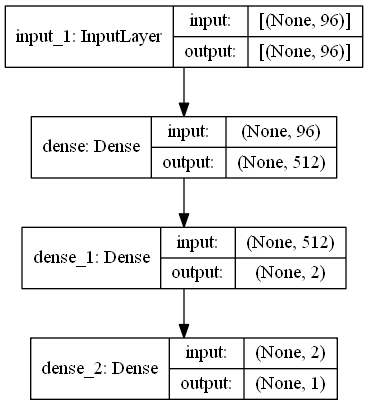

In [13]:
plot_model(model, to_file='best_mlp.png', show_shapes=True)

# GRU


  0%|                                            | 0/5 [00:00<?, ?it/s]

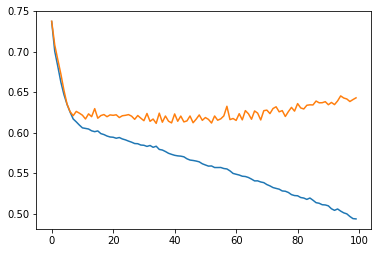

2
train
mae: 0.6278
rmse: 0.8133
me: -0.0126
val
mae: 0.6643
rmse: 0.8539
me: -0.0304
test
mae: 0.6502
rmse: 0.8399
me: -0.0227





 20%|███████▏                            | 1/5 [00:20<01:22, 20.66s/it]

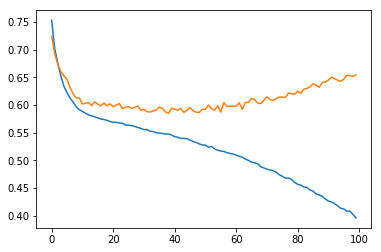

3
train
mae: 0.5934
rmse: 0.7759
me: -0.0401
val
mae: 0.6357
rmse: 0.8191
me: -0.0601
test
mae: 0.6366
rmse: 0.8284
me: -0.0663





 40%|██████████████▍                     | 2/5 [00:45<01:06, 22.01s/it]

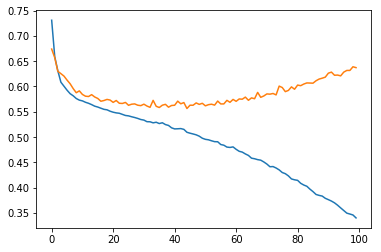

4
train
mae: 0.5508
rmse: 0.7329
me: -0.0188
val
mae: 0.6043
rmse: 0.7822
me: -0.0109
test
mae: 0.6167
rmse: 0.8061
me: -0.0129





 60%|█████████████████████▌              | 3/5 [01:15<00:48, 24.45s/it]

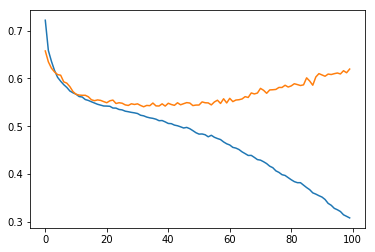

5
train
mae: 0.5643
rmse: 0.7439
me: -0.0385
val
mae: 0.5877
rmse: 0.7626
me: -0.0229
test
mae: 0.5998
rmse: 0.7828
me: -0.0246





 80%|████████████████████████████▊       | 4/5 [01:52<00:28, 28.03s/it]

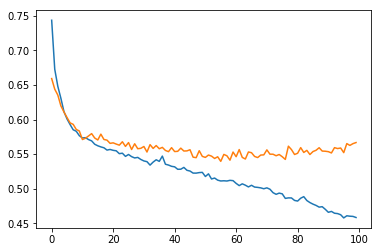

6
train
mae: 0.5556
rmse: 0.7365
me: -0.0734
val
mae: 0.5861
rmse: 0.7641
me: -0.0531
test
mae: 0.5928
rmse: 0.7800
me: -0.0513





100%|████████████████████████████████████| 5/5 [02:33<00:00, 32.02s/it]

In [12]:
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0
sequences = [2,3,4,5,6]

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(inp)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model


for s in tqdm(sequences) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    model = get_model()
    
    checkpoint = ModelCheckpoint('./model/gru_mean_wo_gauss{}.h5'.format(seq_len), save_best_only=True, verbose=0)

    hist = model.fit(np.array(x_train), np.array(y_train), 
                     callbacks=[checkpoint],
                     validation_data=(np.array(x_valid), np.array(y_valid)), 
                     batch_size=batch_size, epochs=epochs, verbose=0) 

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.show()

    model.load_weights('./model/gru_mean_wo_gauss{}.h5'.format(seq_len))
    
    print(seq_len)
    pred_train = model.predict(x_train)
    print('train')
    y_train = hb_scaler_mean.inverse_transform(y_train)
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    evaluate(y_train, pred_train)

    pred_valid = model.predict(x_valid)
    print('val')
    y_valid = hb_scaler_mean.inverse_transform(y_valid)
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    evaluate(y_valid, pred_valid)

    pred_test = model.predict(x_test)
    print('test')
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    evaluate(y_test, pred_test)
    
    print()
    print()

In [8]:
seq_len = 6
learning_rate = 0.001
def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(inp)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 16)]           0         
_________________________________________________________________
gru (GRU)                    (None, 6, 256)            210432    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                61824     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 272,521
Trainable params: 272,521
Non-trainable params: 0
_________________________________________________________________


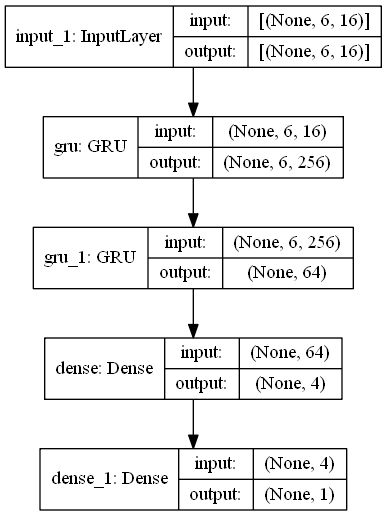

In [15]:
plot_model(model, to_file='best_gru.png', show_shapes=True)

# GRU with Gaussian Noise


  0%|                                            | 0/5 [00:00<?, ?it/s]

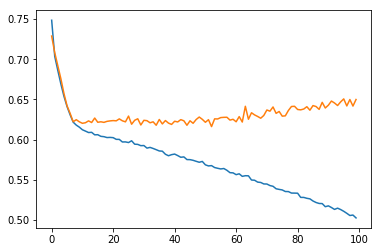

2
train
mae: 0.6074
rmse: 0.7934
me: 0.0144
val
mae: 0.6694
rmse: 0.8601
me: 0.0170
test
mae: 0.6571
rmse: 0.8449
me: 0.0165





 20%|███████▏                            | 1/5 [00:19<01:19, 19.76s/it]

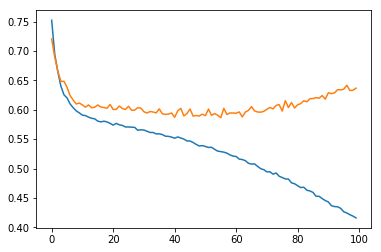

3
train
mae: 0.5644
rmse: 0.7465
me: 0.0217
val
mae: 0.6372
rmse: 0.8207
me: 0.0115
test
mae: 0.6338
rmse: 0.8197
me: 0.0197





 40%|██████████████▍                     | 2/5 [00:45<01:04, 21.41s/it]

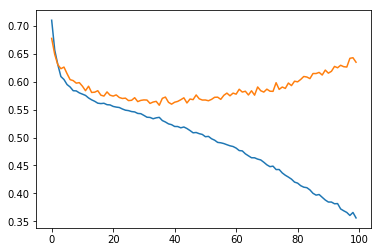

4
train
mae: 0.5698
rmse: 0.7467
me: -0.0053
val
mae: 0.6061
rmse: 0.7862
me: -0.0269
test
mae: 0.6138
rmse: 0.7982
me: 0.0151





 60%|█████████████████████▌              | 3/5 [01:15<00:48, 24.27s/it]

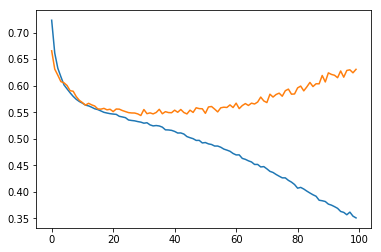

5
train
mae: 0.5708
rmse: 0.7490
me: -0.0200
val
mae: 0.5907
rmse: 0.7632
me: -0.0033
test
mae: 0.6017
rmse: 0.7858
me: -0.0198





 80%|████████████████████████████▊       | 4/5 [01:52<00:27, 27.82s/it]

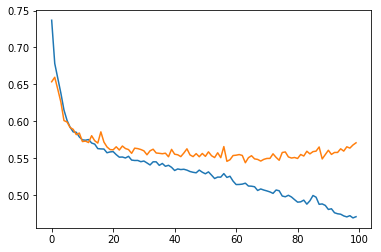

6
train
mae: 0.5483
rmse: 0.7259
me: 0.0163
val
mae: 0.5908
rmse: 0.7665
me: 0.0221
test
mae: 0.5985
rmse: 0.7789
me: 0.0129





100%|████████████████████████████████████| 5/5 [02:33<00:00, 31.76s/it]

In [10]:
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0
sequences = [2,3,4,5,6]

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model


for s in tqdm(sequences) :
    seq_len = s
    
    with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
        loaded_data = pickle.load(f)
    [[x_train,y_train,_],[x_valid,y_valid,_],[x_test,y_test,_]] = loaded_data
    
    model = get_model()
    
    checkpoint = ModelCheckpoint('./model/gru_mean_{}.h5'.format(seq_len), save_best_only=True, verbose=0)

    hist = model.fit(np.array(x_train), np.array(y_train), 
                     callbacks=[checkpoint],
                     validation_data=(np.array(x_valid), np.array(y_valid)), 
                     batch_size=batch_size, epochs=epochs, verbose=0) 

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.show()

    model.load_weights('./model/gru_mean_{}.h5'.format(seq_len))
    
    print(seq_len)
    pred_train = model.predict(x_train)
    print('train')
    y_train = hb_scaler_mean.inverse_transform(y_train)
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    evaluate(y_train, pred_train)

    pred_valid = model.predict(x_valid)
    print('val')
    y_valid = hb_scaler_mean.inverse_transform(y_valid)
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    evaluate(y_valid, pred_valid)

    pred_test = model.predict(x_test)
    print('test')
    y_test = hb_scaler_mean.inverse_transform(y_test)
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    evaluate(y_test, pred_test)
    
    print()
    print()

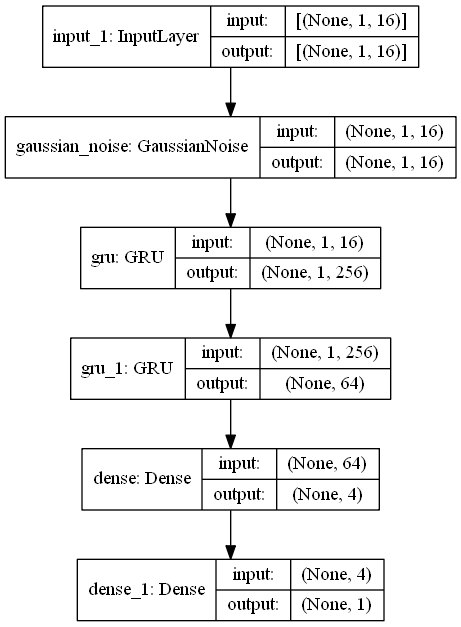

In [9]:
def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model
model = get_model()
plot_model(model, to_file='best_gru_gauss.png', show_shapes=True)

# Performance by Hospital

In [6]:
seq_len = 6
learning_rate = 0.001
epochs = 100
batch_size = 2048 
seed = 0

def get_model():        
    K.clear_session()
    np.random.seed(seed)
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])
    return model

model = get_model()
model.load_weights('./model/gru_mean_{}.h5'.format(seq_len))

In [38]:
with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pickle.load(f)
[[x_train,y_train,train_info],[x_valid,y_valid,valid_info],[x_test,y_test,test_info]] = loaded_data

In [39]:
train_info = np.array([i[0] for i in train_info[:,0]])
valid_info = np.array([i[0] for i in valid_info[:,0]])
test_info = np.array([i[0] for i in test_info[:,0]])

In [45]:
for h in ['A', 'B', 'D', 'E', 'F', 'G', 'H']:
    print('Hospital:', h)
    
    pred_train = model.predict(x_train[train_info==h])
    print('train')
    pred_train = hb_scaler_mean.inverse_transform(pred_train)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_train[train_info==h]), pred_train))

    pred_valid = model.predict(x_valid[valid_info==h])
    print('val')
    pred_valid = hb_scaler_mean.inverse_transform(pred_valid)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_valid[valid_info==h]), pred_valid))

    pred_test = model.predict(x_test[test_info==h])
    print('test')
    pred_test = hb_scaler_mean.inverse_transform(pred_test)
    print('mae:', MAE(hb_scaler_mean.inverse_transform(y_test[test_info==h]), pred_test))

    print()
    print()    

Hospital: A
train
mae: 0.5523
val
mae: 0.6053
test
mae: 0.7004


Hospital: B
train
mae: 0.5198
val
mae: 0.5909
test
mae: 0.5964


Hospital: D
train
mae: 0.6036
val
mae: 0.8274
test
mae: 0.7812


Hospital: E
train
mae: 0.5907
val
mae: 0.6294
test
mae: 0.5709


Hospital: F
train
mae: 0.533
val
mae: 0.5606
test
mae: 0.5851


Hospital: G
train
mae: 0.5254
val
mae: 0.541
test
mae: 0.5708


Hospital: H
train
mae: 0.5679
val
mae: 0.5572
test
mae: 0.5999


